# FMCW-Radar-107_Micro-Doppler

You can open this workbook in Google Colab to experiment with mmWrt
[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/micro_doppler.ipynb)

Below is an intro to mmWrt for simple micro doppler estimation


In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt

from os.path import abspath, join, pardir
import sys
from numpy import arange, array, expand_dims, pi, sin, where, zeros
from numpy import complex128 as complex
from numpy.fft import fft, fftshift, fft2, fftshift, fftfreq
from scipy.signal import find_peaks, stft

import matplotlib.pyplot as plt
from numpy import arange, cos, sin, pi, zeros

from mmWrt.Scene import Antenna, Medium
from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402

from mmWrt.Raytracing import rt_points
from mmWrt import __version__
print("version:", __version__)

print("last run on ", datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
version: 0.0.8-pre.1
last run on  2024-10-27 16:10:25.819591


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

<Figure size 1000x600 with 0 Axes>

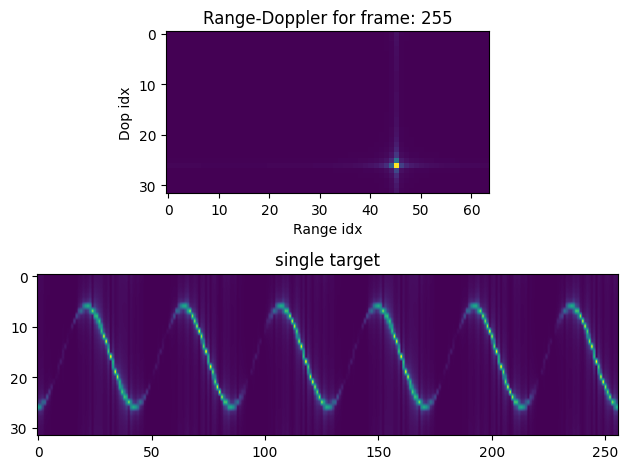

In [ ]:

opt = {"compute":True, "Dres_min":50, "NC":32, "NA":64, "BW":0.01e9, "k":10e12, "fs":100e6, "f0_min":60e9, "NF":256,
        "d0": 300, "v0": 160,
        "TIC":1.2e-6, "TIF": 1.2e-3,
        "logger": "TBD",
        "xt1": "lambda t: d0 + t*v0", "xt": "lambda t: 4*A0*sin(2*pi*f1*t)+d0"}

d0, v0 = opt["d0"], opt["v0"]
NC = opt["NC"]
NA = opt["NA"]
NF = opt["NF"]
BW = opt["BW"]
k = opt["k"]
fs = opt["fs"]
f0_min=opt["f0_min"]
TIF = opt["TIF"]
TIC = opt["TIC"]
F1 = 6
f1 = F1/(NF*TIF)
A0 = v0/(2*pi*f1)

xt = eval(opt["xt"])

radar = Radar(transmitter=Transmitter(bw=BW, slope=k,
                                      f0_min=f0_min,
                                      t_inter_chirp=TIC,
                                      t_inter_frame=TIF,
                                      frames_count=NF,
                                      chirps_count=NC),
              receiver=Receiver(fs=fs, max_adc_buffer_size=1024,
                                max_fs=110e6,
                                n_adc = NA),
             debug=False)


target = Target(xt=lambda t: xt(t))

targets = [target]

bb = rt_points(radar, targets, datatype=complex, raytracing_opt=opt,
               debug=False)

udops1 = zeros((NC, NF))
tx_i, rx_i = 0, 0

for frame_idx in range(NF):
    # compute range doppler
    cube = bb["adc_cube"][frame_idx,:,tx_i,rx_i,:]
    Z_fft2 = abs(fftshift(fft2(cube)))
    # find peak in range
    pk0 = find_peaks(abs(fft(cube[0,:])))[0][0]
    pk1 = find_peaks(abs(fft(cube[-1,:])))[0][0]
    # non regression hook
    assert pk0 == pk1
    # append doppler bin at peak range
    udops1[:,frame_idx] = Z_fft2[:, pk0]
dop_idx = find_peaks(abs(Z_fft2[:, pk0]))[0][0]
# non regression hook
assert dop_idx == 26

plt.figure(figsize=(10,6))
fig, [ax0, ax1] = plt.subplots(nrows=2)
ax0.imshow(abs(Z_fft2))
ax0.set_title(f"Range-Doppler for frame: {frame_idx}")
ax0.set_xlabel("Range idx")
ax0.set_ylabel("Dop idx")
ax1.set_title("single target")
ax1.imshow(udops1, aspect='auto')
plt.tight_layout()

## 2 Targets 180 degrees

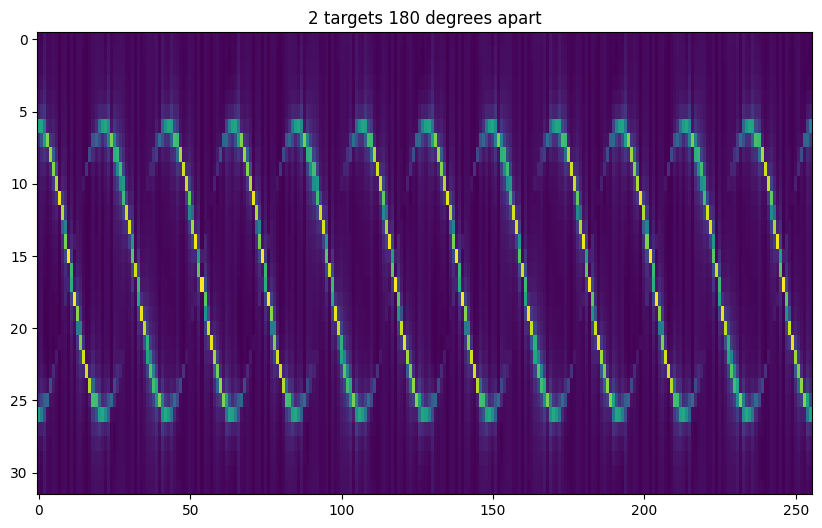

In [ ]:
target_180 = Target(xt=lambda t: xt(t+1/2*1/f1))
bb = rt_points(radar, [target, target_180], datatype=complex, raytracing_opt=opt)

udops = zeros((NC, NF))
pk0 = None
tx_i, rx_i = 0, 0

for frame_idx in range(NF):
    # compute range doppler
    cube = bb["adc_cube"][frame_idx,:,tx_i,rx_i,:]
    Z_fft2 = abs(fftshift(fft2(cube)))
    # find peak in range
    pk = find_peaks(abs(fft(cube[0,:])))[0][0]
    # append doppler bin at peak range
    udops[:,frame_idx] = Z_fft2[:, pk]
plt.figure(figsize=(10,6))
plt.title("2 targets 180 degrees apart")
plt.imshow(udops, aspect='auto')

## 3 Targets each 120 degrees

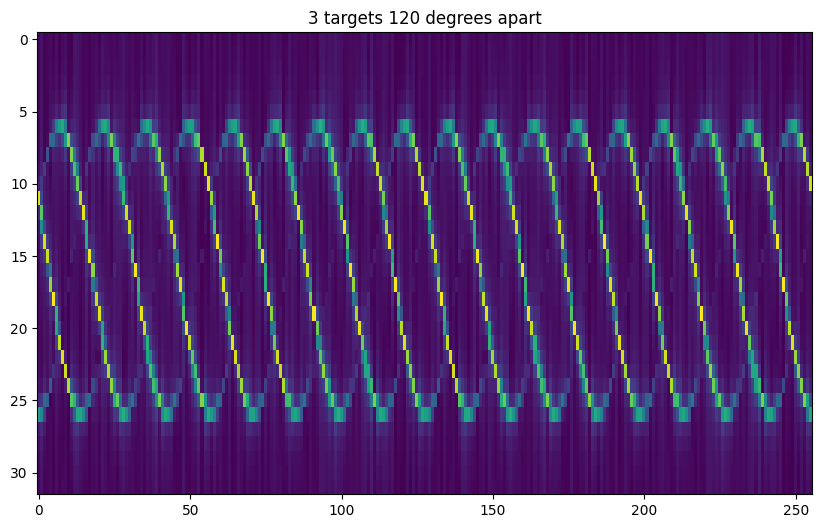

In [ ]:
target_120 = Target(xt=lambda t: xt(t+1/3*1/f1))
target_240 = Target(xt=lambda t: xt(t+2/3*1/f1))
bb = rt_points(radar, [target, target_120, target_240], datatype=complex, raytracing_opt=opt)

udops = zeros((NC, NF))
pk0 = None
tx_i, rx_i = 0, 0

for frame_idx in range(NF):
    # compute range doppler
    cube = bb["adc_cube"][frame_idx,:,tx_i,rx_i,:]
    Z_fft2 = abs(fftshift(fft2(cube)))
    # find peak in range
    pk = find_peaks(abs(fft(cube[0,:])))[0][0]
    # append doppler bin at peak range
    udops[:,frame_idx] = Z_fft2[:, pk]
plt.figure(figsize=(10,6))
plt.title("3 targets 120 degrees apart")
plt.imshow(udops, aspect='auto')

## UDOP w/ STFT

STFT can be used to compute $\mu$-Doppler when there is only one frame available.

Below also shows when one target has just a linear speed and second target is oscillating around the first one.

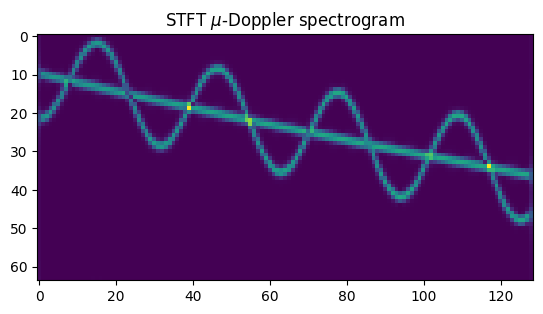

In [ ]:
from scipy.fft import fft, fft2
from numpy import angle, cos, real
from scipy.signal import find_peaks
from scipy.signal import stft

opt = {"compute":True, "Dres_min":50}
debug_ON = False

# chirp start freq
f0m = 60e9
# chirp bandwidth
bw = 1e6
# chirp slope
k=800e6
# t_inter_chirp
t_ic = 2e-3 # 1/2e5
# chirp count
NC=4096
# sampling frequency
fs_if = 20e3
x0, y0, z0 = 500, 0, 500

radar = Radar(transmitter=Transmitter(bw=bw, slope=k,
                                      f0_min=f0m,
                                      t_inter_chirp=t_ic,
                                      chirps_count=NC),
              receiver=Receiver(fs=fs_if, max_adc_buffer_size=60000,
                                debug=debug_ON),
              debug=debug_ON)

xt0 = lambda t: v0*t
xt1 = lambda t: xt0(t) + 1*sin(2*pi*f1*t)

# Targets position and speed
xt0 = lambda t: x0+10*t
# 3 rps
f1 = 0.5
xt1 = lambda t: xt0(t) + 0.1*sin(2*pi*f1*t)
target0 = Target(x0, 0, z0, xt=lambda t: xt0(t))
target1 = Target(x0, 0, z0, xt=lambda t: xt1(t))

bb = rt_points(radar, targets=[target0, target1], debug=debug_ON, raytracing_opt=opt, datatype=complex)
# take the first frame (since only one anyway)
cube = bb["adc_cube"][0,:,0,0,:]
# find the range bin where targets are
range_fft = fft(cube)
peaks, _ = find_peaks(abs(range_fft[0]))  # , height=8)

p0 = peaks[0]
range_bin = range_fft[:,p0]
seg_n = NC//64
_,_,B = stft(range_bin, nperseg=seg_n, return_onesided=False)
C = abs(fftshift(B, axes=0))
C = C[:,]
plt.title("STFT $\mu$-Doppler spectrogram")
plt.imshow(C[:,:])



### Retrieve oscillation data from uDOP

Simples logic: get the doppler peak location, get the FFT index of those and compare to the setting used to create micro-doppler

In [ ]:
NC1, NF1 = udops1.shape

dops = []
for frame_idx in range(NF1):
    dop = find_peaks(udops1[:, frame_idx])[0][0]
    dops.append(dop)
Y = fft(dops)
ym = find_peaks(Y)[0][0]
# non regression hook:
# verify that the frequency measured is the same
# as setup at beginning of simulation
assert ym == F1

In [ ]:
print("last successful run on ")
print(datetime.datetime.now())

last successful run on 
2024-10-27 16:13:46.384196
